In this demo, we compute explanations for the ResNet-50 trained on ImageNet, where we use a custom segmentation mask to define superpixels (similar to the implementation of the LIME explanation).

We first load required packages, the ResNet model and its preprocessing pipeline. Two classes are needed to compute the explanations. `BeamSearchExplainer` implements the beam search algorithm, and `*Masker` implements the feature masking. In this demo, we use `ImageSegmentationMasker` since we need to mask out individual superpixels from an image input. The other demos showcase other `*Maskers`.

In [1]:
from solvex import BeamSearchExplainer, ImageSegmentationMasker
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import skimage
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision.models import resnet50

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = resnet50(weights='IMAGENET1K_V2').to(device)
model.eval()
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

The explainer expects the function to be explained in a particular format. Specifically, it takes in a list of `N` (full or masked) inputs, and returns a `numpy` array of shape `N x C` where `C` is the number of classes. The values of the array can be anything, but most commonly the class probability, which is what we are going to do here. In addition, when masking features (i.e., superpixels) from an image, `ImageSegmentationMasker` expects the image to be a `PIL.Image.Image` object and returns another such object. Thus, `imgs` is a list of `PIL.Image.Image` objects.

In [2]:
def model_func(imgs):
    imgs = torch.stack([preprocess(img) for img in imgs], dim=0).to(device)
    with torch.no_grad():
        logits = model(imgs)
    probs = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()
    return probs

Next we prepare the input image and instantiate the explainer. `ImageSegmentationMasker` takes an argument `fill_value` that specifies the masking operation. In this case, we replace the pixel value with the average pixel value of the entire image. Other options include `'local_mean'` of the superpixel and fixed pixel values in the format of an `uint8` number `v` or an `uint8` 3-tuple `(r, g, b)`.

In [3]:
# download the image and resize to have shorter side length of 224 pixels
url = 'https://yilunzhou.github.io/solvability/cat_and_dog.jpg'
image = Image.open(BytesIO(requests.get(url).content))
ratio =  224 / min(image.size)
image = image.resize((np.array(image.size) * ratio).astype('int32'))

masker = ImageSegmentationMasker(fill_value='global_mean')
explainer = BeamSearchExplainer(masker, f=model_func, beam_size=50, batch_size=50)

We need to define the segmentation mask for the image. A mask is a 2D integer matrix of the same height and width as the image, and values start from 0, where pixels of the same number belong to the same superpixel segment. We use the SLIC algorithm, implemented by the scikit-image package (note that the algorithm can produce fewer than the requested 40 segments; in our case, we have 29). We can visualize the mask using `matplotlib`.

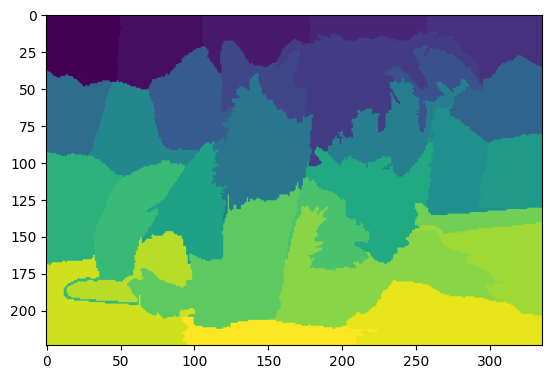

In [4]:
seg_mask = skimage.segmentation.slic(image, n_segments=40, start_label=0)
plt.imshow(seg_mask)
plt.show()

Now we are ready to explain! The image shows a dog and a cat, and we are interested in which pixels contribute the most to each label. Since there are multiple ImageNet classes for different dog and cat species, we choose the class with the highest predicted probability for each, which is class 232 (Border collie) for dog (15.9%) and class 285 (Egyptian cat) for cat (1.0%). In `explain_instance`, we specify the target class via the `label` argument, and the segmentation mask via the `seg_mask` argument. If `label` is not provided, the label with the highest function value will be used. The `seg_mask` argument is not a standard argument to the function, but instead "extra information" provided to the explainer, which passes all such information to `ImageSegmentationMasker`. For more information about how this works, see this advanced tutorial of implementing custom maskers.

In [5]:
e_dog = explainer.explain_instance(image, label=232, seg_mask=seg_mask)  # Border collie
e_cat = explainer.explain_instance(image, label=285, seg_mask=seg_mask)  # Egyptian cat

100%|█████████████████████████████████| 29/29 [01:04<00:00,  2.21s/it]


The explanation `e_dog`/`e_cat` we get is a dictionary of keys `'exp'`, `'label'` and `'func_val'`, of type `list`, `int` and `float` respectively, as printed out below.

In [6]:
print(e_dog)

{'exp': [13.5, 6.5, 21.5, 19.5, 14.5, 25.5, -1.5, 24.5, 18.5, 1.5, 4.5, -2.5, 20.5, 3.5, 12.5, 9.5, 22.5, -0.5, 2.5, 17.5, 0.5, 23.5, 11.5, 8.5, 10.5, 15.5, 16.5, 7.5, 5.5], 'label': 232, 'func_val': 0.15883905}


Even better, all built-in `*Masker` classes include more user-friendly explanation displays, and the `ImageSegmentationMasker` class has two. They can be called with `masker.render_result`, using different `mode` parameters. The first one is console printing.

In [7]:
masker.render_result(image, e_dog, mode='text', execute=True)

Explained label: 232
Function value for label 232: 0.159
Superpixel feature attribution:
+------------------+------------+
| Superpixel idx   |   Attr val |
|------------------+------------|
| Superpixel 0     |       13.5 |
| Superpixel 1     |        6.5 |
| Superpixel 2     |       21.5 |
| Superpixel 3     |       19.5 |
| Superpixel 4     |       14.5 |
| Superpixel 5     |       25.5 |
| Superpixel 6     |       -1.5 |
| Superpixel 7     |       24.5 |
| Superpixel 8     |       18.5 |
| Superpixel 9     |        1.5 |
| Superpixel 10    |        4.5 |
| Superpixel 11    |       -2.5 |
| Superpixel 12    |       20.5 |
| Superpixel 13    |        3.5 |
| Superpixel 14    |       12.5 |
| Superpixel 15    |        9.5 |
| Superpixel 16    |       22.5 |
| Superpixel 17    |       -0.5 |
| Superpixel 18    |        2.5 |
| Superpixel 19    |       17.5 |
| Superpixel 20    |        0.5 |
| Superpixel 21    |       23.5 |
| Superpixel 22    |       11.5 |
| Superpixel 23    |       

The second one is color overlay on top of the input image (i.e., the typical saliency map visualization).

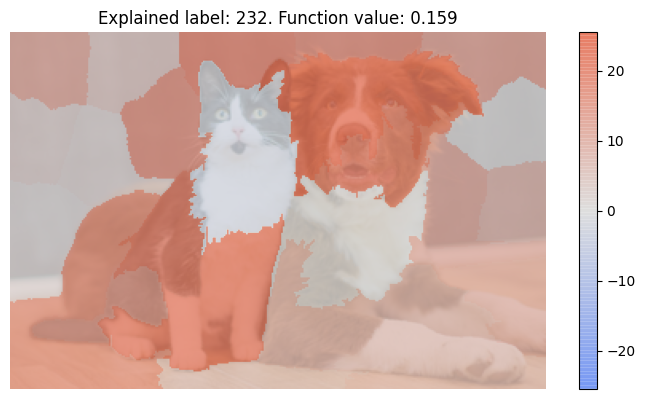

In [8]:
masker.render_result(image, e_dog, mode='color', execute=True, seg_mask=seg_mask)

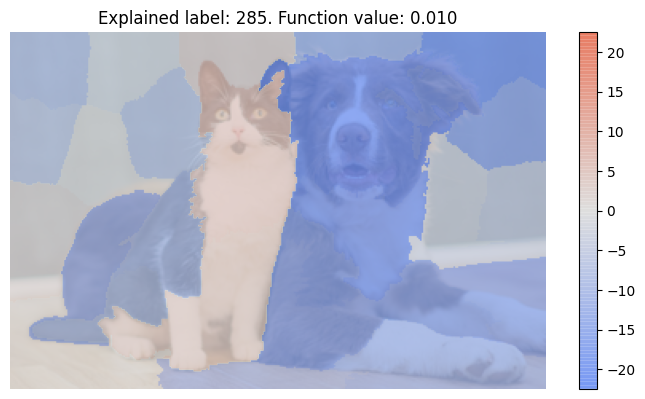

In [9]:
masker.render_result(image, e_cat, mode='color', execute=True, seg_mask=seg_mask)

For the dog class explanation, most regions on the dog have very positive influence (red colors), while those on the cat face have mildly negative influence (blue colors). Curiously, the lower cat body regions has high positive influence -- probably the model confusing them as dog body parts?

For the cat class explanation, regions on the dog have very negative influence, meaning that their removal would significantly increase predicted probability for the cat class. By comparison, none of the features have strong positive influence. This also makes sense: we define a feature to have high positive influence if its removal greatly decreases the predicted probability, but the current probability of 1.0% is already quite low!

And that's it! Want to learn more? Check out the other tabs for more use cases. If you want to gain a deeper understanding of the `*Masker` classes and implement your own, check out this jupyter notebook for an example where we build one from scratch and browse the documentations. Bugs? Suggestions? Questions? Ask away on [GitHub](https://github.com/YilunZhou/solvability-explainer)!

